In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA = Path("../data")
REPORT = Path("../report")
REPORT.mkdir(exist_ok=True)

# Load without forcing a date column
df = pd.read_csv(DATA / "cleaned_master.csv", low_memory=False)

# Try to detect/construct a datetime column, then standardize name -> transaction_time
date_candidates_ordered = [
    "transaction_time", "time_of_transactions", "transaction_date",
    "date", "datetime", "timestamp", "time"
]
dt_col = next((c for c in date_candidates_ordered if c in df.columns), None)

if dt_col:
    df["transaction_time"] = pd.to_datetime(df[dt_col], errors="coerce", infer_datetime_format=True)
else:
    # Heuristic: try to parse any object column that looks like a date
    dt_col = None
    for c in df.columns:
        if df[c].dtype == "object":
            s = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
            if s.notna().mean() > 0.5:  # parsed successfully for most rows
                df["transaction_time"] = s
                dt_col = c
                break

if "transaction_time" in df.columns:
    df["year"] = df["transaction_time"].dt.year
    df["month"] = df["transaction_time"].dt.to_period("M")
    df["week"] = df["transaction_time"].dt.isocalendar().week.astype("Int64")
else:
    print("No usable date column found; time-based analyses will be skipped.")


C:\Users\sik2k\AppData\Local\Temp\ipykernel_42324\2337203277.py:21: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["transaction_time"] = pd.to_datetime(df[dt_col], errors="coerce", infer_datetime_format=True)


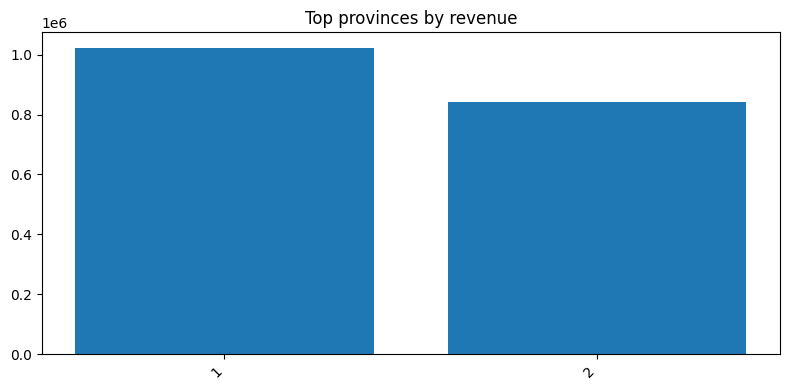

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

REPORT = Path("../report")
df = pd.read_csv("../data/cleaned_master.csv", low_memory=False)

if {"province","amount"}.issubset(df.columns):
    prov = df.groupby("province", as_index=False)["amount"].sum().sort_values("amount", ascending=False).head(10)
    plt.figure(figsize=(8,4))
    plt.bar(prov["province"].astype(str), prov["amount"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Top provinces by revenue")
    plt.tight_layout()
    plt.savefig(REPORT / "fig_top_provinces.png", dpi=150)


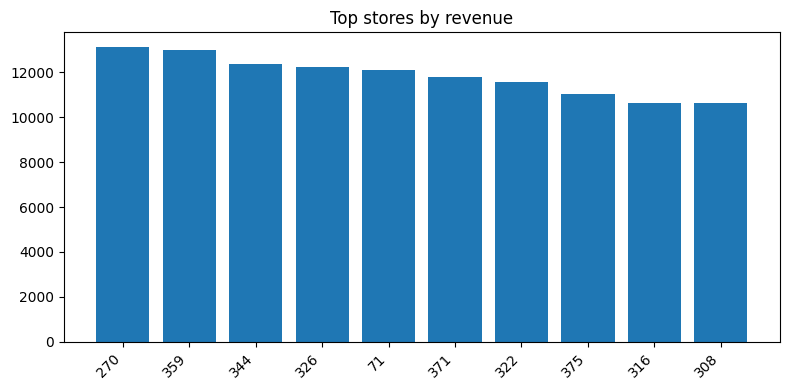

In [3]:
if {"supermarket_no","amount"}.issubset(df.columns):
    stores = df.groupby("supermarket_no", as_index=False)["amount"].sum().sort_values("amount", ascending=False).head(10)
    plt.figure(figsize=(8,4))
    plt.bar(stores["supermarket_no"].astype(str), stores["amount"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Top stores by revenue")
    plt.tight_layout()
    plt.savefig(REPORT / "fig_top_stores.png", dpi=150)


In [4]:
import pandas as pd, numpy as np
df = pd.read_csv("../data/cleaned_master.csv", low_memory=False, parse_dates=["transaction_time"], infer_datetime_format=True)

# Promotion uplift (global)
df["promo_flag"] = 0
for c in ["feature","display"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().replace({"nan":"0","None":"0"})
        df.loc[df[c].ne("0"), "promo_flag"] = 1

uplift = np.nan
if {"amount","promo_flag"}.issubset(df.columns):
    g = df.groupby("promo_flag")["amount"].mean()
    base, promo = g.get(0, np.nan), g.get(1, np.nan)
    if pd.notna(base) and base != 0: uplift = (promo - base) / base * 100

# Top provinces/stores/items tables
prov = df.groupby("province", as_index=False)["amount"].sum().sort_values("amount", ascending=False).head(5) if "province" in df.columns else None
stores = df.groupby("supermarket_no", as_index=False)["amount"].sum().sort_values("amount", ascending=False).head(5) if "supermarket_no" in df.columns else None
items = df.groupby("code", as_index=False)["amount"].sum().sort_values("amount", ascending=False).head(5) if "code" in df.columns else None

print("Promotion uplift (mean amount):", f"{uplift:.2f}%" if pd.notna(uplift) else "N/A")
print("\nTop provinces:\n", prov if prov is not None else "N/A")
print("\nTop stores:\n", stores if stores is not None else "N/A")
print("\nTop items:\n", items if items is not None else "N/A")


C:\Users\sik2k\AppData\Local\Temp\ipykernel_42324\2682461875.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("../data/cleaned_master.csv", low_memory=False, parse_dates=["transaction_time"], infer_datetime_format=True)


ValueError: Missing column provided to 'parse_dates': 'transaction_time'

C:\Users\sik2k\AppData\Local\Temp\ipykernel_42324\3460640648.py:15: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.to_datetime(df[src], errors="coerce", infer_datetime_format=True)


Average promotion uplift: N/A

Wrote: C:\Users\sik2k\Git_Repo\supermart-analytics-assignment\report\insights_to_paste.md


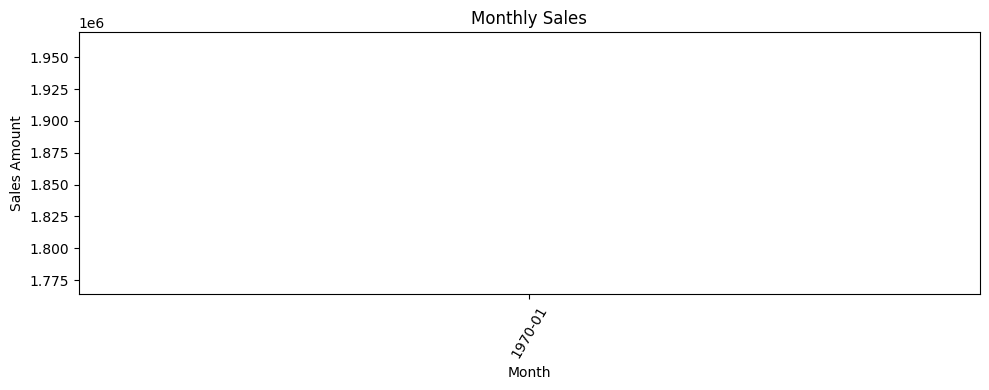

In [6]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

DATA   = Path("../data")
REPORT = Path("../report"); REPORT.mkdir(exist_ok=True)

# 1) Load without forcing a date column
df = pd.read_csv(DATA / "cleaned_master.csv", low_memory=False)

# 2) Try to construct a usable datetime named 'transaction_time'
date_candidates = ["transaction_time","time_of_transactions","transaction_date",
                   "date","datetime","timestamp","time"]
src = next((c for c in date_candidates if c in df.columns), None)
if src:
    dt = pd.to_datetime(df[src], errors="coerce", infer_datetime_format=True)
    if dt.notna().any():
        df["transaction_time"] = dt

# 3) Time features if available
if "transaction_time" in df.columns:
    df["year"]  = df["transaction_time"].dt.year
    df["month"] = df["transaction_time"].dt.to_period("M")
    df["week"]  = df["transaction_time"].dt.isocalendar().week.astype("Int64")

# 4) Promotion flag (robust)
for c in ["feature","display"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().replace({"nan":"0","None":"0"})
df["promo_flag"] = 0
if "feature" in df.columns: df.loc[df["feature"].ne("0"), "promo_flag"] = 1
if "display" in df.columns: df.loc[df["display"].ne("0"), "promo_flag"] = 1

# 5) Monthly sales chart (if possible)
if {"month","amount"}.issubset(df.columns):
    m = df.dropna(subset=["month"]).groupby("month", as_index=False)["amount"].sum().sort_values("month")
    plt.figure(figsize=(10,4))
    plt.plot(m["month"].astype(str), m["amount"])
    plt.title("Monthly Sales"); plt.xlabel("Month"); plt.ylabel("Sales Amount")
    plt.xticks(rotation=60); plt.tight_layout()
    plt.savefig(REPORT / "fig_monthly_sales.png", dpi=150)
    m.to_csv(REPORT / "table_monthly_sales.csv", index=False)

# 6) Promotion uplift (global)
uplift = np.nan
if {"amount","promo_flag"}.issubset(df.columns):
    g = df.groupby("promo_flag")["amount"].mean()
    base, promo = g.get(0, np.nan), g.get(1, np.nan)
    if pd.notna(base) and base != 0 and pd.notna(promo):
        uplift = (promo - base) / base * 100
print("Average promotion uplift:", "N/A" if pd.isna(uplift) else f"{uplift:.2f}%")

# 7) Top provinces / stores / items (saved for report)
if {"province","amount"}.issubset(df.columns):
    prov = df.groupby("province", as_index=False)["amount"].sum().sort_values("amount", ascending=False)
    prov.to_csv(REPORT / "table_revenue_by_province.csv", index=False)
else:
    prov = None

if {"supermarket_no","amount"}.issubset(df.columns):
    stores = df.groupby("supermarket_no", as_index=False)["amount"].sum().sort_values("amount", ascending=False)
    stores.to_csv(REPORT / "table_top_stores.csv", index=False)
else:
    stores = None

if {"code","amount"}.issubset(df.columns):
    items = df.groupby("code", as_index=False)["amount"].sum().sort_values("amount", ascending=False)
    items.to_csv(REPORT / "table_top_items.csv", index=False)
else:
    items = None

# 8) Quick paste-ready summary for your business report
lines = []
lines.append(f"Promotion uplift (mean amount): {'N/A' if pd.isna(uplift) else f'{uplift:.2f}%'}")
if prov is not None:
    lines.append("\nTop provinces (by revenue):")
    for _, r in prov.head(5).iterrows(): lines.append(f"- {r['province']}: {r['amount']:.0f}")
if stores is not None:
    lines.append("\nTop stores (by revenue):")
    for _, r in stores.head(5).iterrows(): lines.append(f"- {r['supermarket_no']}: {r['amount']:.0f}")
if items is not None:
    lines.append("\nTop items (by revenue):")
    for _, r in items.head(5).iterrows(): lines.append(f"- {r['code']}: {r['amount']:.0f}")

(REPORT / "insights_to_paste.md").write_text("\n".join(lines), encoding="utf-8")
print("\nWrote:", (REPORT / "insights_to_paste.md").resolve())
